# Content based recommender for the Movie Lense data set

Based on [this article](https://www.kaggle.com/code/indralin/movielens-project-1-1-content-based) and [this one](https://medium.com/analytics-vidhya/content-based-recommender-systems-in-python-2b330e01eb80)

Objective: To build a recommender system that recommends movies based on the plot of a previously watched movie.

![picture](https://miro.medium.com/max/640/0*lhH61OnvbJFWrykk.webp)<br><br>

The Content-Based Recommender relies on the **similarity** of the items being recommended.<br>

The basic idea is that if you like an item, then you will also like a “similar” item. <br>

It generally works well when it's easy to determine the context/properties of each item.

Content-Based method also solve **_Cold Start problem_**.<br>

If we're visiting an e-commerce / video platform for the first time, they won't know anything about us. So how can they give a great recommendation for us?<br>
### Basic solution:

- First, recommend the best selling products or some latest releases
- After we see / click on some product, they will pick products with similar content to recommend us

![]('media/content_based.webp')

# import the libraries and install dependencies

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

# Load/read the dataset without any formatting

In [11]:
rating_df = pd.read_csv(r'data/archive/rating.csv')

In [3]:
movie_df = pd.read_csv(r'data/archive/movie.csv')

In [4]:
rating_df.shape

(20000263, 4)

In [5]:
rating_df.head(10)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
5,1,112,3.5,2004-09-10 03:09:00
6,1,151,4.0,2004-09-10 03:08:54
7,1,223,4.0,2005-04-02 23:46:13
8,1,253,4.0,2005-04-02 23:35:40
9,1,260,4.0,2005-04-02 23:33:46


In [18]:
movie_df=pd.read_csv(r'https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset?select=movies.csv',  on_bad_lines='skip')

In [19]:
movie_df.shape

(99, 1)

In [20]:
movie_df.head(10)

,<!DOCTYPE html>
0,"<html lang=""en"">"
1,<head>
2,<title>Movie Lens Small Latest Dataset | Kag...
3,"<meta charset=""utf-8"" />"
4,"<meta name=""description"" content=""Benchmark ..."
5,"<meta name=""turbolinks-cache-control"" conten..."
6,"<meta name=""theme-color"" content=""#008ABC"" />"
7,"<script nonce=""7L5Mtf93OderaB7G46vjng=="" typ..."
8,"window[""pageRequestStartTime""] = 167026537..."
9,"window[""pageRequestEndTime""] = 1670265379964;"



# Load Dataset with reduce memory technique

uint8 Unsigned integer (0 to 255) <br>
uint16 Unsigned integer (0 to 65535)<br>
uint32 Unsigned integer (0 to 4294967295)<br>
uint64 Unsigned integer (0 to 18446744073709551615)<br>

**_userId & movieId don't have a negative values, use uint (no negative value) can help us to reduce memory, since we use a large dataset_**



In [30]:
rating_df = pd.read_csv(r'data/archive/rating.csv', parse_dates=['timestamp'], dtype={'userId': 'uint32', 'movieId': 'uint32', 'rating': 'float32'})
movie_df = pd.read_csv(r'data/archive/movie.csv', dtype={'movieId': 'uint32'})



In [9]:
rating_df.shape

(20000263, 4)

In [10]:
rating_df.head(10)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
5,1,112,3.5,2004-09-10 03:09:00
6,1,151,4.0,2004-09-10 03:08:54
7,1,223,4.0,2005-04-02 23:46:13
8,1,253,4.0,2005-04-02 23:35:40
9,1,260,4.0,2005-04-02 23:33:46


In [11]:
movie_df.shape

(27278, 3)

In [12]:
movie_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller



# Data Cleaning

- Both datasets don't have missing or duplicated values
- Add new features using datetime for analysist & EDA



In [31]:
# use the parsed timestamp and add new columns out of it for the year and month
rating_df['gave_rating_year'] = rating_df['timestamp'].dt.year
rating_df['gave_rating_month'] = rating_df['timestamp'].dt.month_name().str[:3]

In [14]:
rating_df.shape

(20000263, 6)

In [15]:
rating_df.head(10)

,userId,movieId,rating,timestamp,gave_rating_year,gave_rating_month
0,1,2,3.5,2005-04-02 23:53:47,2005,Apr
1,1,29,3.5,2005-04-02 23:31:16,2005,Apr
2,1,32,3.5,2005-04-02 23:33:39,2005,Apr
3,1,47,3.5,2005-04-02 23:32:07,2005,Apr
4,1,50,3.5,2005-04-02 23:29:40,2005,Apr
5,1,112,3.5,2004-09-10 03:09:00,2004,Sep
6,1,151,4.0,2004-09-10 03:08:54,2004,Sep
7,1,223,4.0,2005-04-02 23:46:13,2005,Apr
8,1,253,4.0,2005-04-02 23:35:40,2005,Apr
9,1,260,4.0,2005-04-02 23:33:46,2005,Apr


In [16]:
movie_df.shape

(27278, 3)

In [17]:
movie_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### drop timestamp

In [32]:
# get rid of the timestamp column
rating_df.drop('timestamp', axis=1, inplace=True)

In [6]:
rating_df.shape

(20000263, 3)

In [7]:
rating_df.head(10)

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
5,1,112,3.5
6,1,151,4.0
7,1,223,4.0
8,1,253,4.0
9,1,260,4.0


In [8]:
movie_df.shape

(27278, 3)

In [9]:
movie_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### sentimental analysis of the ratings

In [33]:
rating_df['sentiment_analysis'] = rating_df['rating'].map({
    0.5: 'Negative', 1.0: 'Negative', 1.5: 'Negative', 2.0: 'Negative', 2.5: 'Negative',
    3.0: 'Neutral', 3.5: 'Neutral',
    4.0: 'Positive', 4.5: 'Positive', 5.0: 'Positive'
})

In [11]:
rating_df.head(3)

,userId,movieId,rating,sentiment_analysis
0,1,2,3.5,Neutral
1,1,29,3.5,Neutral
2,1,32,3.5,Neutral


In [12]:
movie_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


# Merge

In [ ]:
final_df = pd.merge(rating_df, movie_df, on='movieId', how='inner')  # by default ‘inner’



In [14]:
final_df.shape

(20000263, 6)

In [15]:
final_df.head()

,userId,movieId,rating,sentiment_analysis,title,genres
0,1,2,3.5,Neutral,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Neutral,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Neutral,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Neutral,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Neutral,Jumanji (1995),Adventure|Children|Fantasy


# Visualization

In [16]:
movie_genres = []

for genre in movie_df['genres']:
    for movie in genre.split('|'):
        movie_genres.append(movie)

In [17]:
genre_counts = pd.Series(movie_genres).value_counts()[:18]

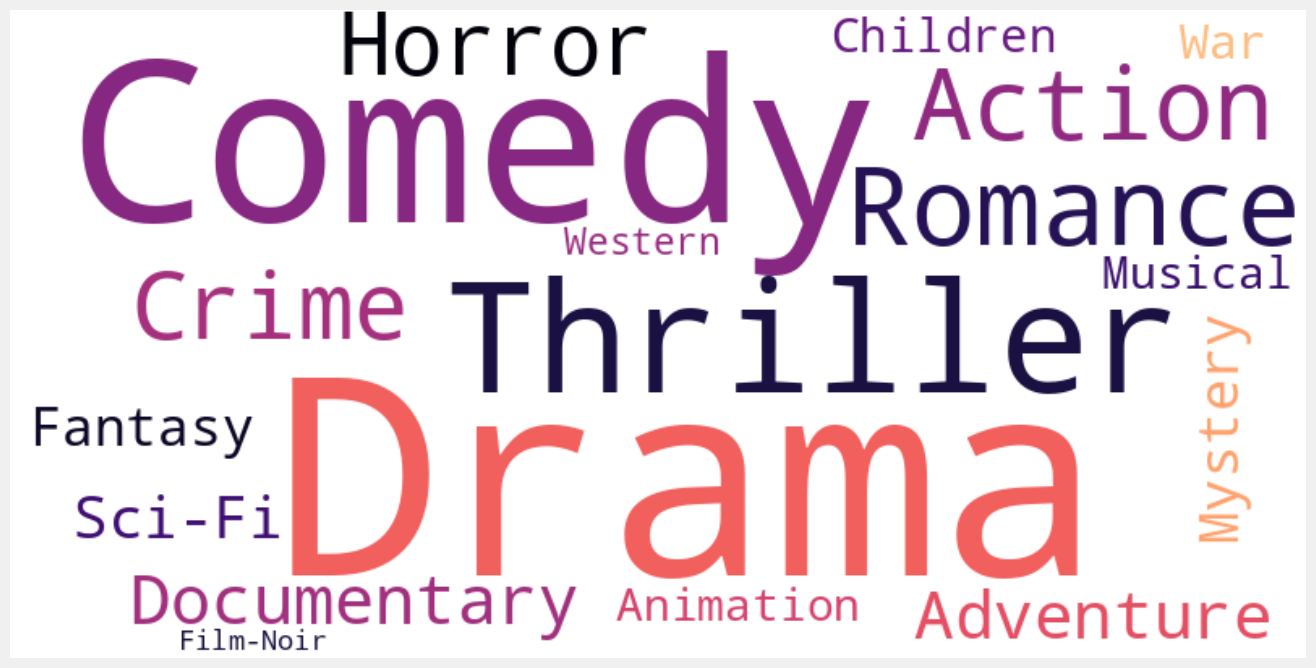

In [19]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='magma')
genres_cloud.generate_from_frequencies(genre_counts)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

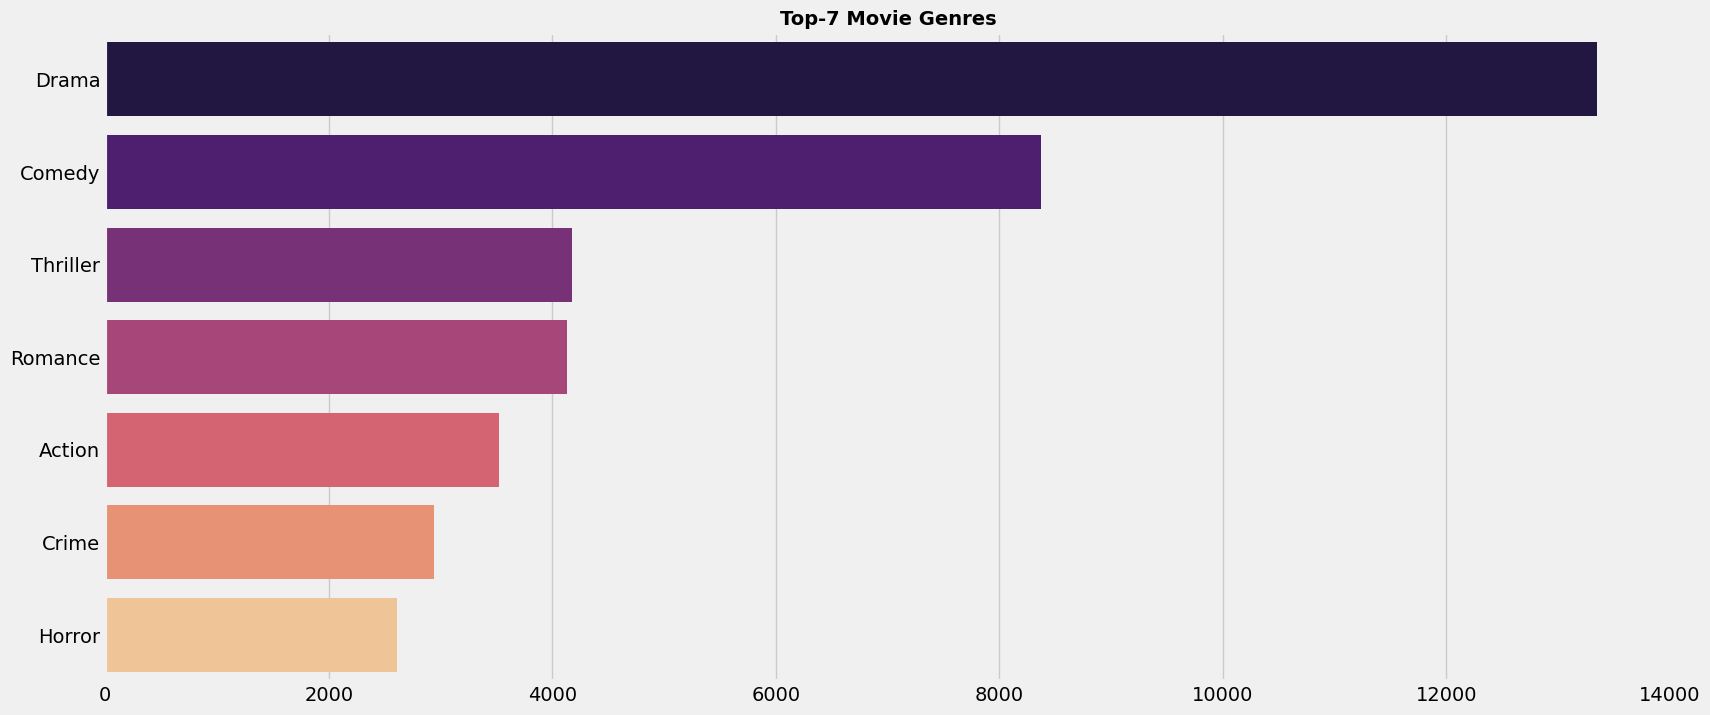

In [20]:
top_7_genres = pd.Series(movie_genres).value_counts()[:7]

sns.barplot(y=top_7_genres.index, x=top_7_genres.values, palette='magma').set_title(
        'Top-7 Movie Genres', fontsize=14, weight='bold')

plt.show()

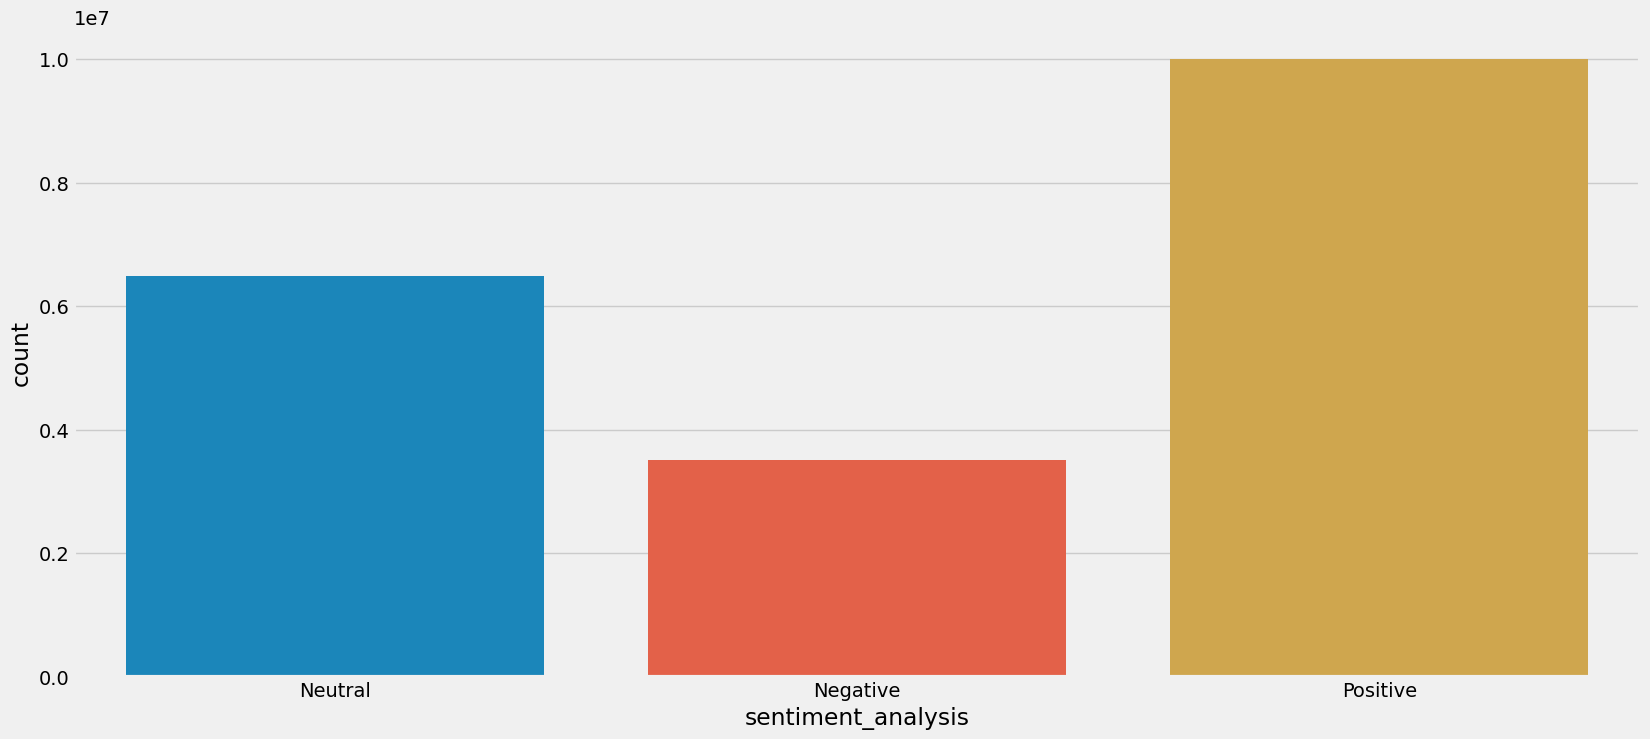

In [26]:
splot1 = sns.countplot(x=final_df['sentiment_analysis'])

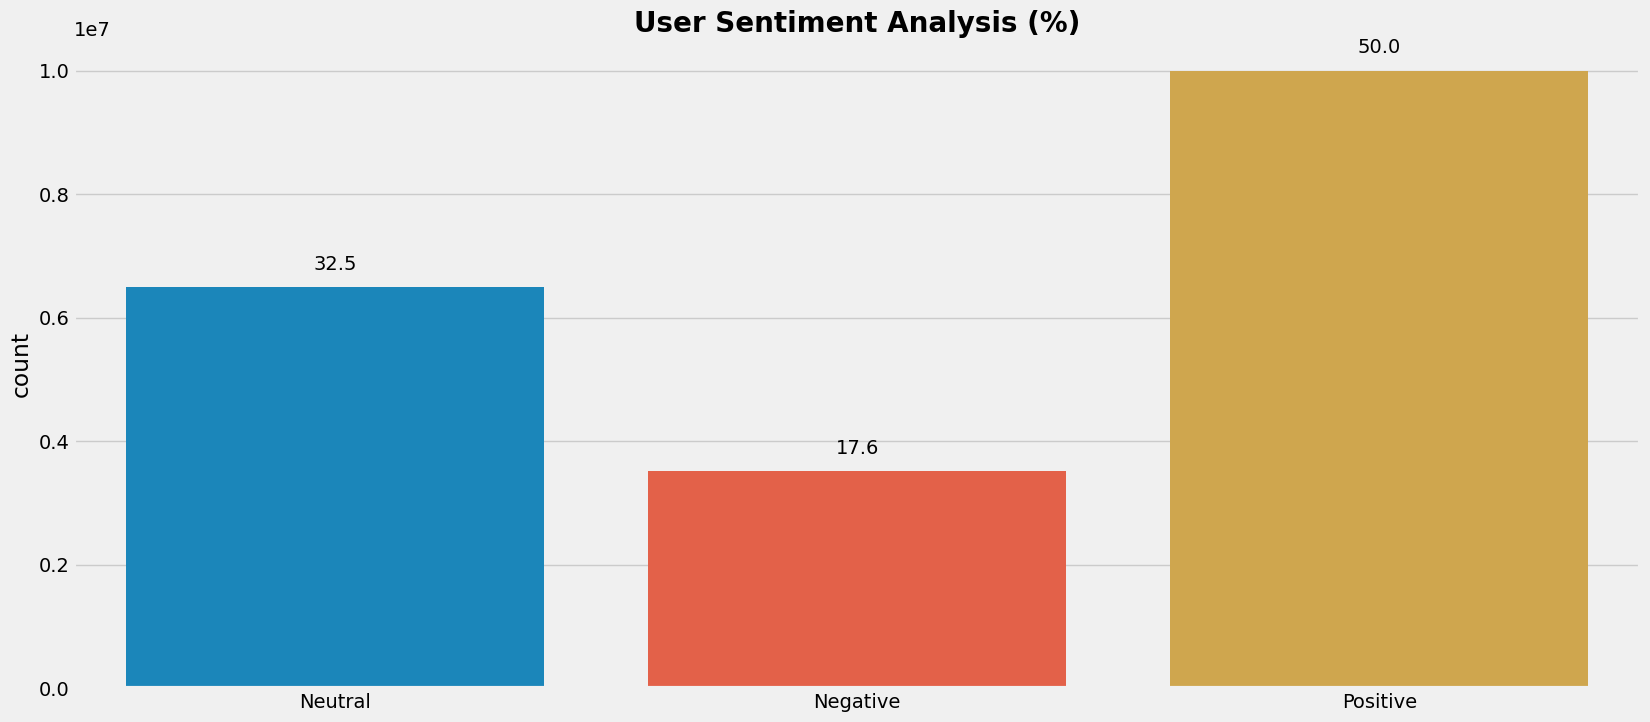

In [27]:
# refine the plot and add labels and information to it
splot1 = sns.countplot(x=final_df['sentiment_analysis'])
for p in splot1.patches:
                splot1.annotate(format(p.get_height() / final_df['rating'].shape[0] * 100, '.1f'),
                                (p.get_x() + p.get_width() / 2., p.get_height()),
                               rotation=0, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')
        
plt.xlabel(None)
plt.title('User Sentiment Analysis (%)', fontsize=20, weight='bold')
plt.show()

From total 138493 users

- 50% users gave positive rating
- 32.5% users are neutral
- 17.6% users gave negative rating

In [ ]:
def plot_progress_year(feature, title):
    rating_progress = final_df.groupby(feature)['userId'].count()
    
    plt.plot(rating_progress, linestyle='-', marker='o', markersize=10)
    plt.title(title, fontsize=16)
    plt.xticks([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], rotation=30)
    plt.ylim([0, 2100000])
    plt.show()

plot_progress_year('gave_rating_year', 'Progress rating count per year')

    * If you like old movies, maybe this dataset can give good recommendation for you.
    * But this might not be suitable for those of you who like new movies

In [ ]:
df_index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_progress = final_df.groupby('gave_rating_month').userId.count().reindex(df_index)

plt.plot(month_progress, linestyle='-', color='red', marker='o', markersize=10)
plt.title('Progress rating count by month')
plt.ylim([1250000, 2100000])
plt.show()

- Many people watch movies at near the end of the year
- Perhaps because they get a holiday, or a lot of good movies come out at that time

# Machine Learning model (TF-IDF vectorizer + Cosine Similarity)

![](https://miro.medium.com/max/720/1*V9ac4hLVyms79jl65Ym_Bw.webp)
[source](https://ted-mei.medium.com/demystify-tf-idf-in-indexing-and-ranking-5c3ae88c3fa0)


- TF is simply the frequency of a word in a document
- IDF is the inverse of the document frequency among the whole corpus of documents


Example: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view

**_In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document)._**


In [ ]:
genres_str = movie_df['genres'].str.split('|').astype(str)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0)
tfidf_matrix = tfidf.fit_transform(genres_str)


In [ ]:
tfidf_matrix.shape  # banyak karena n-gram (1,2)
# tfidf.get_feature_names()

## Cosine-Similarity

- Cosine similarity takes the angle between two non-zero vectors and calculates the cosine of that angle, and this value is known as the similarity between the two vectors
- This similarity score ranges from 0 to 1, with 0 being the lowest (the least similar) and 1 being the highest (the most similar).
- If the angle between two vectors is 0°, then the similarity would be 1. Conversely, if the angle between two vectors is 90°, then the similarity would be 0. For two vectors with an angle greater than 90°, then we also consider those to be 0.


![projection of 3d documents](https://www.machinelearningplus.com/wp-content/uploads/2018/10/3d_projection-865x922.png)
[source](https://www.machinelearningplus.com/nlp/cosine-similarity/)

**The smaller the angle, the higher the cosine similarity**

1- As you can see, Doc Dhoni_Small and the main Doc Dhoni are oriented closer together in 3-D space, even though they are far apart by magnitiude.<br>
2- It’s important to note that only the angle between the two vectors is considered, and not the magnitude of the vectors.


In [ ]:
# Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

- Now we have a pairwise cosine similarity matrix for all the movies in the dataset.
- The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score.

In [ ]:
indices = pd.Series(movie_df.index, index=movie_df['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title, similarity=False):
    
    if similarity == False:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11] # you can change to 20 movies, even more
    
        movie_indices = [i[0] for i in sim_scores]
    
        return pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values})
    
    
    elif similarity == True:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        
        movie_indices = [i[0] for i in sim_scores]
        similarity_ = [i[1] for i in sim_scores]
        
        return pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values,
                             'Similarity': similarity_})

# Make a Movie Recommendation

    With 3 different solutions



In [ ]:
genre_recommendations('Kung Fu Panda (2008)', similarity=True)

In [ ]:
genre_recommendations("Indiana Jones and the Temple of Doom (1984)", similarity=True)


# Problem in this recommendation:

- This system only recommend similar movie
- But remember, a few years can make a big difference in quality, especially in sci-fi or animation movies
- Maybe some user can think this is a bad recommendation system, because give them an old movies recommendation

Perhaps you like old movies like me, but some people doesn't like old movies, so it's depends on your users¶



In [ ]:
movie_df['movie_release_year'] = movie_df['title'].str.extract(r'(?:\((\d{4})\))?\s*$', expand=False)

In [ ]:
## option 2

def genre_recommendations_2(title, most_recent=False):
    
    if most_recent == False:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:10] # you can change to 20 movies, even more
    
        movie_indices = [i[0] for i in sim_scores]
    
        return pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values})
    
    
    elif most_recent == True:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:14]
        
        movie_indices = [i[0] for i in sim_scores]
        
        most_recent_movie = pd.DataFrame({'Movie': movie_df['title'].iloc[movie_indices].values,
                                          'release_year': movie_df['movie_release_year'].iloc[movie_indices].values})
        
        return most_recent_movie.sort_values('release_year', ascending=False).head(10)

- We can sort by movie_release_year to give a better recommendation
- Even system still recommend this old movies, but we can put it behind a new movie
- In top-n recommender (only recommend 5 - 10 items per row), users only see newest movie

In [ ]:
genre_recommendations_2('Green Hornet, The (2011)', most_recent=True)


### Another options:

- Sort by rating mean to recommend movies with a high rating
- Sort by total rating



In [ ]:
rating_mean = final_df.groupby('title')['rating'].mean().reset_index()
total_rating = final_df.groupby('title')['rating'].count().reset_index()

total_rating_mean = pd.merge(rating_mean, total_rating, on='title', how='inner')
total_rating_mean.rename(columns={'rating_x': 'rating_mean',
                                  'rating_y': 'total_rating'},
                                  inplace=True)

final_df2 = movie_df.merge(total_rating_mean, on='title', how='left').dropna()

In [ ]:
## option 3

def genre_recommendations_3(title, best_rating=False):
    
    if best_rating == False:  # sort by total rating
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:14]
    
        movie_indices = [i[0] for i in sim_scores]
        
        most_rating_movie = pd.DataFrame({'Movie': final_df2['title'].iloc[movie_indices].values,
                                          'total_rating': final_df2['total_rating'].iloc[movie_indices].values})
    
        return most_rating_movie.sort_values('total_rating', ascending=False).head(10)
    
    
    elif best_rating == True:  # sort by best rating
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:14]
        
        movie_indices = [i[0] for i in sim_scores]
        
        most_recent_movie = pd.DataFrame({'Movie': final_df2['title'].iloc[movie_indices].values,
                                          'rating_mean': final_df2['rating_mean'].iloc[movie_indices].values})
        
        return most_recent_movie.sort_values('rating_mean', ascending=False).head(10)

In [ ]:
genre_recommendations_3('Taken (2008)', best_rating=True)

In [ ]:
genre_recommendations_3('Taken (2008)', best_rating=False)


### Overall, here are the pros of using content-based recommendation:

1-No need for data on other users, thus no cold-start or sparsity problems.
2- Can recommend to users with unique tastes.
3- Can recommend new & unpopular items.
4- Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

### However, there are some cons of using this approach:

1- Finding the appropriate features is hard.
2- Does not recommend items outside a user's content profile.
3- Unable to exploit quality judgments of other users.

    The problem of this method: it will always be limited to the same type of movie the user see in the past

